# An Intriguing Failing of Neural Network Papers and the SpecIt Solution

A semiprofessional hobby of mine is replicating the results of machine learning papers. In contrast to other kinds of science, machine learning should be relatively easy to replicate. Many canonical datasets are freely available, and there are semi-fungible replacements for others. Theoretic papers often use synthetic datasets for their experiments. Generally, no fieldwork or physical experimental setup is necessary. 

However, I find that many papers are underconstrained, especially in their description of the models used. It’s common to leave out details like the activation(s) used, the details of convolutions, or the learning rate scheduler. Less frequently, core details like the fundamental structure of a network are fully omitted or heavily obfuscated.

I will share here an anecdote of my attempt to replicate the [CoordConv paper](https://arxiv.org/abs/1807.03247), and some thoughts on how it relates to the state of ML papers in general with respect to replication.

### My CoordConv anecdote

The CoordConv paper was published earlier this year and deals with convolutional neural networks performing tasks in coordinate spaces - a category that includes most computer vision tasks. The technique described in the paper is somewhat intuitive but deserves thorough investigation and testing. [Some](https://blog.piekniewski.info/2018/07/14/autopsy-dl-paper/) railed against this paper with the criticism that it is “obvious,” but I do not agree with this assessment. [[1]](#[1]). 

The paper describes several simple tasks that CNNs learn very poorly: converting a coordinate vector to a one-hot image vector picking out that coordinate, the inverse regression task converting the one-hot vector to a coordinate vector, and finally 2D rendering of a geometric shape centered at a coordinate vector. Each task is attempted with a traditional convolutional network that upsamples the input vector to the image size through a series of deconvolutions (except in the case of regression). Performance is shockingly poor. 

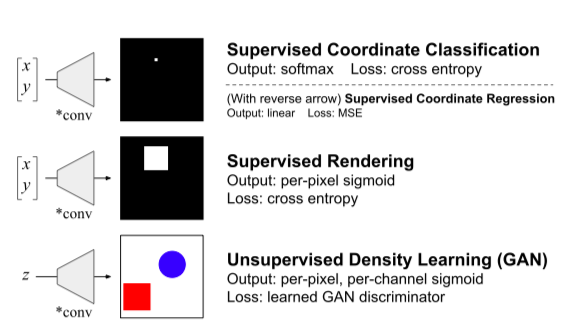
*From [Li et al.](https://arxiv.org/pdf/1807.03247.pdf)*

The CoordConv layer is introduced, which simply augments a standard convolution by appending untrained X and Y coordinate channels to the input activations. Networks using a one-shot scaleup of the input vector convolved with a CoordConv layer learn the above tasks as trivially as our intuition would have hoped. Everyone goes home happy. 

I actually wasn’t planning to replicate this paper - it *is* quite simple, outside of some of the GAN tasks - but I wanted to use the technique in another context, and just attempted to implement the supervised rendering task. Based on how simple the CoordConv training process was described to be, I expected this to take about half of an hour. I implemented the exact model they described, which, in the first layer, tiles the input vector over the original image shape and performs 1x1 CoordConv convolution. My replication checklist for the paper was okay: no activation function was specified (usually NBD), but the convolutions were mostly parameterized and the paper helpfully described the spatial shape after each layer.

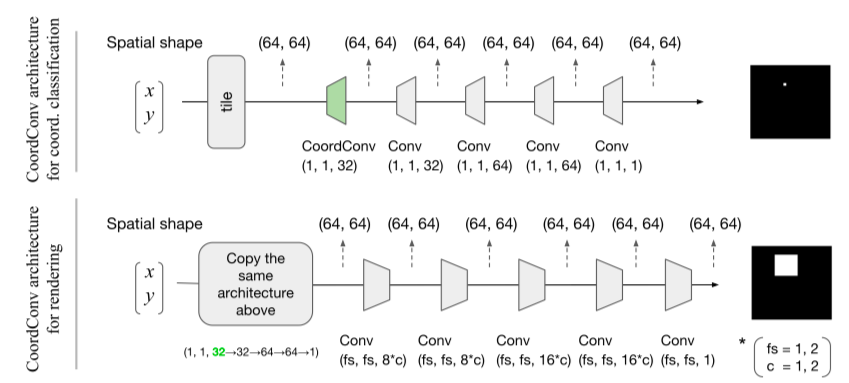
*From [Li et al.](https://arxiv.org/pdf/1807.03247.pdf)*

And yet, my model failed to train on the parameter settings they described. After jacking up the filter size beyond the bounds that the paper described, I finally started to get some descent, but the results were still bad. After spending an hour fiddling with the model and checking for bugs, I couldn’t figure out what was going on. I knew there must be something very wrong either with my implementation, or with the paper’s description of their model. 

I dropped down to the simpler coordinate classification task and created a dataset for it, but the network again failed to learn the task. Generally, my training runs would converge to outputting an empty image - which would give a constant loss in the datasets I was using. After penalizing this behavior by hand, I started to see strange cross-shaped output activations, which was my first hint. I’d stared at the description of “tile” in the original paper for a while previously. In the GAN section, they describe tiling the latent vector to the original image size, apparently in one channel. This would be something like:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

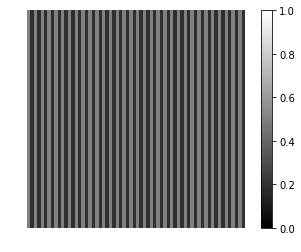

In [8]:
coord = (32, 12)
spatial_shape = (64, 64)
z = np.array(coord) / np.array(spatial_shape)
tiled = np.tile(z, np.prod(spatial_shape) // z.size).reshape(spatial_shape)
plt.imshow(tiled, cmap='gray', vmin = 0, vmax = 1)
plt.colorbar()
_ = plt.axis('off')

Surely, I thought, this must be the same as what they meant by “tile” in the classification and rendering models, especially given the fact that the CoordConv layer in those models is defined as taking in one channel.

And yet, this could not be the case: the paper specified convolutional filter sizes of 1 and 2 as resulting in valid training runs. If the 2D input vector is tiled in one channel, and every convolution is 1x1, it is impossible for the network to learn the desired behavior. The best it can do is “cross-shaped” rendering - because each output pixel will only ever have a receptive field of one pixel in the original image.

After realizing that tiling was the issue, I replaced the tile operation in one channel with a tile operation in N channels (where N is the size of the input vector). This is something like:

In [9]:
tiled = (z.repeat(np.prod(spatial_shape))
         .reshape(z.shape + spatial_shape))

We can see the results by plotting:

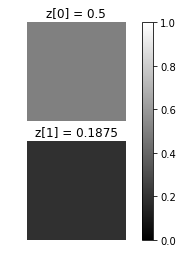

In [10]:
fig, ax = plt.subplots(z.shape[0],1)
for i in range(tiled.shape[0]):
    ax[i].set_axis_off()
    ax[i].set_title(f'z[{i}] = {z[i]}')
    im = ax[i].imshow(tiled[i], cmap='gray', vmin = 0, vmax = 1)
    
_ = fig.colorbar(im, ax=ax.ravel().tolist())

After making this change, I was able to make the networks for classification and rendering train to zero or negligible error in seconds, even when using 1x1 convolutions. The reason is simple: this method of tiling ensures that even 1x1 convolutions will have both spatial coordinates in the receptive field of each output pixel. It is trivial for a network to learn the transform from this three channel input to the correct one channel output in either the classification or rendering tasks [[2]](#[2]). 

### What went wrong and what goes wrong

If “tile” has been more clearly described in the paper, or described at all, I probably would have finished building and testing the rendering network in less than the original amount of time I expected it to take. To make matters even more frustrating, I still don’t know if the change I made was the same as the implementation used by the paper authors. 

However, I don’t think that this pitfall was really a failing of the CoordConv paper in isolation. In actuality, the CoordConv paper's models are much better parameterized and much more easily replicable than the majority of papers I look at. I almost always see a poorly specified baseline model, an element of network architecture completely unspecified, and/or completely unspecified models for non-toy problems (in papers with a toy problem and more complicated subsequent applications). Often, the only description of the experiment is the number of epochs run, the losses achieved, and the compute time on some cluster. Most ML papers do not seem to be written with the assumption that their experiments will be closely replicated.

As a result, is very difficult to closely replicate the results of a paper or the models described in it, even when it is very easy to implement and use the described techniques in isolation of the original experimental setup. I do not envy those who publish quantitative review papers in this field. But if we think of the field itself with no preconceptions, it seems that it should be easy to replicate these papers! Why are there so many free variables? Why do I have to turn key details like the choice of activation function into hyperparameter search grid axes?

There are several "smartass" answers:

1. The entire field is a hype-driven reseach bubble filled with papers that don't introduce quantitative performance improvements (but claim to).
1. The field is moving so fast that most results are thrown into conference papers or preprints and abandoned without ever being cleaned up, reviewed, and/or published.
1. Researchers expect to be contacted directly by anyone who wants to replicate their paper.

Each of these may have a kernel of truth to them, but I think all largely miss the mark. Furthermore, they are abstract complaints with no clear potential for action (except perhaps the final one). We can break down the more concrete, actionable reasons for the difficulty of replication into a few categories. 

First, we do not have consistent guidelines for notation of neural networks and other model structures. I feel like I see a new style of drawing or specifying NNs or PGMs in every paper I read. At least for models with static structure, we should be specifying the model structure completely, ideally in a format that can be ingested by ML libraries directly. The main benefit of a machine-readable format isn’t to save some time in recreating a model from a diagram, it’s to make sure that it is possible to exactly replicate the model structure used in a paper without confusion. 

Second, code is not always published, especially in the preprint stage. This field is filled with independent and industry researchers and driven by arXiv: it isn’t helpful if supplemental materials show up months later in an institutional access database. The CoordConv paper includes a small code appendix that... describes how to generate X-Y coordinate matrices... but no code for any of the models they use, or for the experimental setup of even the toy problems. It’s fine to not publish code, and there are many reasons why it might not be feasible for a given paper, especially for industry researchers. Hoewever, I believe that but there should be a higher expectation for experimental specification if you don’t provide code.

Finally, I feel that there is a pervasive attitude against this kind of complete replication in ML. When a paper like CoordConv comes out, plenty of people try to apply the technique elsewhere and report improvements in their ablation studies or what have you, but often don’t try to reconstruct the original experiments first. I found lots of CoordConv implementations online, but very few with the experimental setup for any of the toy problems, and none with all of them. This process fails to guarantee the baseline assumption that everyone is using the same technique - there could be subtle, significant differences between implementations that don’t show up unless the original experiments are attempted. This is especially true with a research community split between several libraries with significant differences - for example, what if the padding setup in my PyTorch convolutions doesn’t quite replicate TF’s “same” mode?

### Paths forward

These issues are not standing still. The number of papers coming out of OpenAI and Google's research units with published code is encouraging [[3]](#[3]). [OpenAI Baselines](https://github.com/openai/baselines/) and the various ModelZoos are other good steps forward. The ongoing work on ONNX and similar programs is an important step towards a common format. On the other hand, contemporary moves away from simple network models to more complicated and exotic training setups, such as GANs, RL training harnesses, and dynamic model structures mean that network diagrams and specification tables are less and less likely to capture all of the specification necessary to fully describe a model. In addition, the ongoing proliferation of new architecture units--self attention mechanisms, recurrent cells, and the like--means that the creation of novel and valuable model architectures often outpaces the formalization of their components parts.

Here are some common ways that authors, in my experience, can easily improve the replicability of their papers:

1. Specify the characteristics and training methods of baseline models/methods.
1. Describe the places where a novel method connects to techniques already in the literature - this is the category of the CoordConv "tile" ambiguity.
1. Specify experimental parameters like batch size and floating point precision. Each of these may or may not be important depending on context.
1. Go through the code for your model and list every detail of it. Check and see if these details are in your paper.
1. Have a colleague or student try to replicate the paper in isolation - this would be a good undergrad independent research project.

### Replication Challenge

I hereby invite all readers who do work in the context of machine learning to the **Replication Challenge: try to replicate one machine learning paper, from scratch, and see if you can achieve the same results as the authors of the paper.**

Does the paper describe its models (including baselines) well enough to implement them? 
Can you achieve the same learning profiles? 
Can you at least get a similar loss with the same number of epochs? 
Do you observe the same performance relative to the baseline models the paper describes? 
Can you tune the baselines a little and reduce the performance gap significantly?

Let me know if you are able to do this, what results you run into, and what roadblocks you run into. 

# Notes

###### [1] 
The relegation of so-called “tricks” like spatial bias to an oral tradition of arcane magic that grad students learn from their advisors is a huge problem. Getting this stuff on paper is important - maybe we need a global ML cookbook project, but for now papers are how most people learn and communicate. The "research note" format might also be valuable here.

Also, as far as I can tell, the preprint has never even been submitted to a conference or journal, so I'm not really sure what all the fuss is about, this paper is not taking airtime away from anybody else.

###### [2]
The classification task can be solved perfectly using only two 1x1 convolutions (one hidden layer):

- CoordConv with 
    - 4 input channels (2 input, 2 coordinate over the coordinate range $[0,1]$), 4 output channels, 
    - 4 filters $[1, 0, -1, 0]$,  $[-1, 0, 1, 0]$, $[0, 1, 0, -1]$, and $[0, -1, 0, 1]$. 
    - Output at each pixel $= \begin{bmatrix}(x-i)\\ (i-x)\\ (y - j)\\ (j - x)\end{bmatrix}$

- ReLU over 4 channels with

    - Output at each pixel $= \begin{bmatrix}(x-i)\cdot\mathbb{1}(x > i)\\ (i-x)\cdot\mathbb{1}(x < i)\\(y - j)\cdot\mathbb{1}(y > j)\\ (j - x)\cdot\mathbb{1}(y < j)\end{bmatrix}$
    
- Conv2 with 4 input channels, 1 output channel, filter $[-1, -1, -1, -1]$, bias of 1:

    - Output at each pixel: 
$1 - \left((x-i)\cdot\mathbb{1}(x > i)+ (i-x)\cdot\mathbb{1}(x < i)+(y - j)\cdot\mathbb{1}(y > j)+ (j - x)\cdot\mathbb{1}(y < j)\right) \\= 1 - (|x-i| + |y-j|)$

The final output here is the negation of the Manhattan distance between (x,y) and (i,j), so the maximum value obtained by it will be located at (x,y). 

Of course, a network with learned weights may not solve this problem in the same way.

In [11]:
def plotims(ims):
    ct = ims.shape[0]
    pltims = ims.detach().reshape((ims.shape[0], 64, 64))
    fig, ax = plt.subplots(1, ct, figsize=(8,8))
    for idx in range(ct):
        ax[idx].imshow(ims[idx], cmap='gray')
        ax[idx].set_title(f"output {idx+1}")

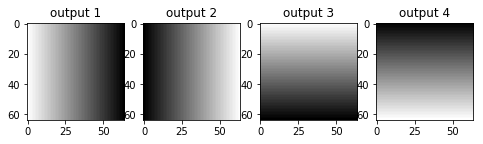

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

im = torch.tensor(tiled, dtype=torch.float)
i = torch.linspace(0, 1, tiled.shape[1]).unsqueeze(0).repeat((tiled.shape[2],1)).unsqueeze(0)
j = torch.linspace(0, 1, tiled.shape[2]).unsqueeze(1).repeat((1, tiled.shape[1])).unsqueeze(0)
x = torch.cat((im, i, j), 0).unsqueeze(0)

filters1 = torch.tensor([
    [1., 0., -1., 0.],
    [-1., 0., 1., 0.],
    [0., 1., 0., -1.],
    [0., -1., 0., 1.]], dtype=torch.float).reshape((4, 4, 1, 1))

conv1 = (F.conv2d(x, filters1, stride=1))
plotims(conv1.reshape((4, 64, 64)))

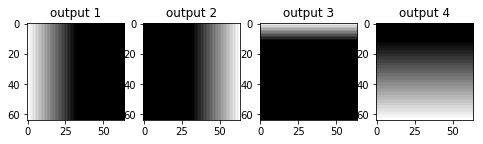

In [13]:
act1 = F.relu(conv1)
plotims(act1.reshape((4, 64, 64)))

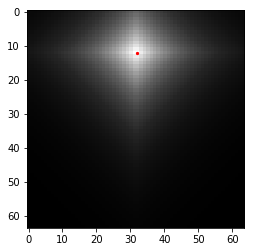

In [20]:
filters2 = torch.tensor([-5., -5., -5., -5], dtype=torch.float).reshape((1, 4, 1, 1))
conv2 = F.softmax((F.conv2d(act1, filters2, bias=torch.ones(1), stride=1)).reshape((-1)), 0)
_ = plt.imshow(conv2.reshape((64, 64)).detach(), cmap='gray')
_ = plt.scatter(z[0]*64, z[1]*64, s=5, color='red')

In a network with just one hidden layer and only 21 weights total, the correct classification location has been found. Note that the network is tuned to display a psuedo-logit here - scaling the weights of the final layer can select the correct location exactly.

###### [3]
Google's impetus to drive Tensorflow and TPU/GCP adoption is probably the main reason for this.